In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, BatchNormalization
from keras.models import Model
from keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Practical: Convolutional autoencoder architectures
In this practical we will look at how to design a convolutional autoencoder architecture. For the encoder, we can use similar architectures as for common classification/regression networks (e.g. VGG-style). Typically, the decoder is then designed to "reverse" the structure of the encoder. For fully connected layers this is straightforward, but for convolutional or pooling layers this leaves some options.

## Data (MNIST)
We'll use MNIST as a simple example. Images are 28x28 pixels, but for convolutional autoencoders with strides or pooling, it is very convenient if the image size is a multiple of the stride/pool size. Typically, we use 2x2 strides/pooling, so we rescale the canvas size of MNIST from 28x28 to 32x32 (since 32=2^5), by padding zeros.

In [3]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# normalise
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# change shape: (n, 28, 28) -> (n, 28, 28, 1)
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

# pad zeros to obtain canvas size of 32x32, i.e. shape is now (n, 32, 32, 1)
x_train = np.pad(x_train, pad_width=((0, 0), (2, 2), (2, 2), (0, 0)), mode="constant", constant_values=0)
x_test = np.pad(x_test, pad_width=((0, 0), (2, 2), (2, 2), (0, 0)), mode="constant", constant_values=0)

# get height, width, and depth values
height, width, depth = x_train.shape[1:]

11493376/11490434 [==============================] - 1s 0us/step


In [32]:
print(x_train.shape)
print(x_test.shape)

(60000, 32, 32, 1)
(10000, 32, 32, 1)


## VGG-like encoder
Let's make a simple VGG-like encoder with 2 convolutional blocks, each consisting of a single convolution and maxpooling, followed by two dense layers. We'll also include batch normalisation.

Let's write the input and output shape of each layer in the comments, to get a better idea of the structure of the network.

In [16]:
# input
x_in = Input(shape=(height, width, depth), name="encoder_input")

# conv block 1
h = Conv2D(filters=64, kernel_size=(3, 3), padding="same",
           activation='relu')(x_in)                    # (32, 32, 1)  -> (32, 32, 64)
h = MaxPooling2D(pool_size=(2, 2), padding="same")(h)  # (32, 32, 64) -> (16, 16, 64)
h = BatchNormalization()(h)                            # no change

# conv block 2
h = Conv2D(filters=128, kernel_size=(3, 3), padding="same",
           activation='relu')(h)                       # (16, 16, 64)  -> (16, 16, 128)
h = MaxPooling2D(pool_size=(2, 2), padding="same")(h)  # (16, 16, 128) -> (8, 8, 128)
h = BatchNormalization()(h)                            # no change

# dense layers
h = Flatten()(h)                                       # (8, 8, 128) -> (8*8*128,)
h = Dense(256, activation="relu")(h)                   # (8*8*128,)  -> (256,)
h = BatchNormalization()(h)                            # no change
h = Dense(128, activation="relu")(h)                   # (256,) -> (128,)
h = BatchNormalization()(h)                            # no change
encoded = Dense(32)(h)                                 # (128,) -> (32,) (encoding dimension)
# NOTE: no activation for the last layer, encoded representations are vectors of real numbers

Instructions for updating:
Colocations handled automatically by placer.


## Decoder architecture: reversing the structure
For our decoder architecture, it seems natural to reverse the structure of the encoder, layer by layer. We could try some weight-tying between encoder and decoder, but typically this is not done; the encoder and decoder each have their own weights that are trained independently.

Reversing the structure of a fully connected layer is simple; use the input size of the encoder layer as the number of output units for the decoder layer.

To reverse convolutional layers (in particular when they are strided), we could use a transposed convolution (often mistakenly called "deconvolution") to reverse its structure. However, this is prone to creating unwanted artifacts, or the checkerboard effect (see https://distill.pub/2016/deconv-checkerboard/ for an excellent explanation). Therefore, we prefer to not use strided convolutions in the encoder, and we use MaxPooling to downsample the size of the activation maps. To reverse this downsampling, we can use the UpSampling layer in Keras (which is essentially nearest-neighbour interpolation as described and recommended in https://distill.pub/2016/deconv-checkerboard/). To "reverse" a non-strided convolution, we can then simply use another normal convolution, where we use the number of input activation maps (filters) in of the encoder conv-layer as the number of output activation maps (filters) for the decoder conv-layer.

Now let's reverse the encoder architecture, making sure that we have the same change in shape for the hidden units, but reversed.

In [0]:
# HOMEWORK: design the decoder architecture, by reversing the encoder architecture
# the reversed order of the shapes is already given as a guide

# (32,) -> (128,) (encoding dimension)
# no change
# (128, -> (256,)
# no change
# (256,)     -> (8*8*128,)
# (8*8*128,) -> (8, 8, 128)

# no change
# (8, 8, 128  ) -> (16, 16, 128)
# (16, 16, 128) -> (16, 16, 64)

# no change
# (16, 16, 64) -> (32, 32, 64)
# (32, 32, 64) -> (32, 32, 1)
# HINT: think about the activation for the last layer, which should represent
#       pixel values between 0 and 1

In [0]:
# SOLUTION:

# reverse dense layers
h = Dense(128, activation="relu")(encoded)  # (32,) -> (128,) (encoding dimension)
h = BatchNormalization()(h)                 # no change
h = Dense(256, activation="relu")(h)        # (128, -> (256,)
h = BatchNormalization()(h)                 # no change
h = Dense(8*8*128, activation="relu")(h)    # (256,)     -> (8*8*128,)
h = Reshape((8, 8, 128))(h)                 # (8*8*128,) -> (8, 8, 128)

# reverse conv block 2
h = BatchNormalization()(h)                 # no change
h = UpSampling2D(size=(2, 2))(h)            # (8, 8, 128  ) -> (16, 16, 128)
h = Conv2D(filters=64, kernel_size=(3, 3), padding="same",
           activation='relu')(h)            # (16, 16, 128) -> (16, 16, 64)

# reverse conv block 2
h = BatchNormalization()(h)                 # no change
h = UpSampling2D(size=(2, 2))(h)            # (16, 16, 64) -> (32, 32, 64)
x_out = Conv2D(filters=1, kernel_size=(3, 3), padding="same",
               activation='sigmoid')(h)     # (32, 32, 64) -> (32, 32, 1)
# NOTE: sigmoid activation for the last layer, since it should represent
#       pixel values between 0 and 1

## Compile, train, and test the model
Let's setup and compile the autoencoder, and do a quick test. We use some loss function to compare the original data with its reconstruction, so we use the training set both as input and target values.

In [19]:
autoencoder = Model(x_in, x_out, name="autoencoder")
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

history = autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=100,
                validation_data=(x_test, x_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 128)         512       
__________

<Figure size 1440x288 with 0 Axes>

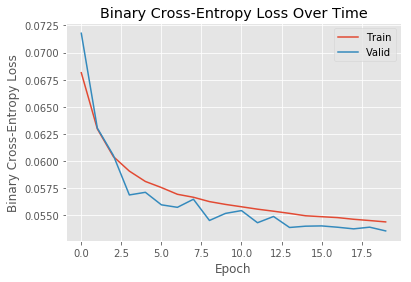

In [28]:
# Plotting the Loss
%matplotlib inline
plt.style.use('ggplot')

plt.figure(figsize=(20, 4))
plt.subplots(nrows=1, ncols=1)
plt.plot(np.log1p(history.history['loss']))
plt.plot(np.log1p(history.history['val_loss']))

plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Binary Cross-Entropy Loss Over Time')
plt.legend(['Train','Valid'])
plt.show()

Reconstruct and visualise some images from the test set.

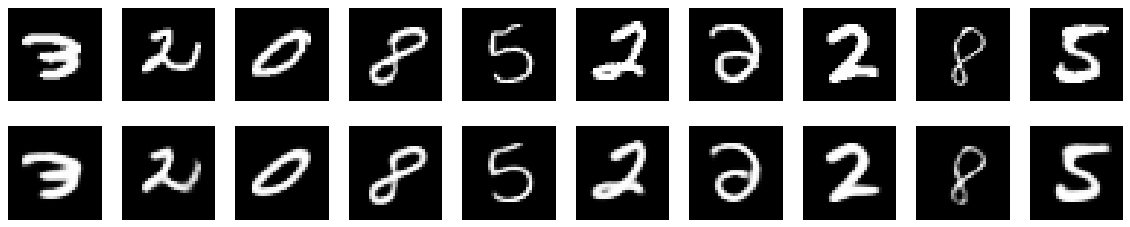

In [29]:
n = 10  # number of images to plot
indices = np.random.choice(len(x_test), size=n, replace=False)
test_imgs = x_test[indices]  # X
reconstr_imgs = autoencoder.predict(test_imgs)  # Y

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_imgs[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstr_imgs[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()